# Data Retrieval

In [1]:
import pandas as pd
from astroquery.utils.tap.core import TapPlus # library to query astronomical databases, TAP services

pd.set_option("display.max_rows", 500) # to display more rows in pandas DataFrames
pd.set_option("display.max_columns", 500)

In [2]:
# Connect to the TAP service
tap = TapPlus(url="http://tap.roe.ac.uk/ssa")

adql = """
SELECT TOP 1000
    z.*,
    p.*
FROM BestDR9.ZooSpec AS z 
JOIN BestDR7.PhotoObj AS p
  ON p.objid = z.dr7objid
"""
#selects all the columns of both tables and joins them on the objid

# Run synchronously, the code will wait until the job is finished, only after that it will continue
# Asynchronous the program sends the adql query and continue running the code
job = tap.launch_job(adql)
results = job.get_results()
df = results.to_pandas() # convert to pandas DataFrame

In [3]:
def safe_to_numeric(col):
    try:
        return pd.to_numeric(col, errors="raise")
    except Exception:
        return col  # leave unchanged if it can't be fully parsed


df = df.apply(safe_to_numeric).set_index("dr7objid")

# Data Filtering


In [4]:
mask = (
    # correct magnitudes
    (df["modelMag_u"] > -30)
    & (df["modelMag_g"] > -30)
    & (df["modelMag_r"] > -30)
    & (df["modelMag_i"] > -30)
    & (df["modelMag_z"] > -30)
    &
    # reasonable errors
    (df["modelMagErr_u"] < 0.5)
    & (df["modelMagErr_g"] < 0.05)
    & (df["modelMagErr_r"] < 0.05)
    & (df["modelMagErr_i"] < 0.05)
    & (df["modelMagErr_z"] < 0.1)
    &
    # very certain about the classification
    ((df["p_cs_debiased"] >= 0.9) | (df["p_el_debiased"] >= 0.9))
    &
    # medium size
    (df["petroR90_r"] * 2 * 1.5 / 0.4 < 64)
    & (df["petroR90_r"] * 2 / 0.4 > 20)
)

In [15]:
cols_to_keep = (
    [
        "specobjid",
        "objid",
        #"dr7objid",
        "ra",
        "dec",
        "p_el_debiased",
        "p_cs_debiased",
        "spiral",
        "elliptical",
    ]
    + ["petroR50_r", "petroR90_r"]
    + [f"modelMag_{f}" for f in "ugriz"]
    + [f"extinction_{f}" for f in "ugriz"]
)
df_filtered = df[mask][cols_to_keep]

In [19]:
from mymodule import clean_data

In [20]:


df_filtered_mymodule = clean_data(df)

NameError: name 'm' is not defined

# Image cutout

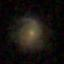

In [9]:
import urllib

from IPython.display import Image, display


IMAGE_PIXSCALE = 0.4  # arcsec/pixel
IMAGE_SIZE_PX = 64
IMAGE_WIDTH_PX = IMAGE_SIZE_PX
IMAGE_HEIGHT_PX = IMAGE_SIZE_PX
OBJECT_INDEX = 1  # which object from the filtered list to download

URL = (
    "https://skyserver.sdss.org/DR19/SkyserverWS/ImgCutout/getjpeg?"
    "ra={ra}&dec={dec}&scale={scale}&width={width}&height={height}"
)

RA = df_filtered.iloc[OBJECT_INDEX]["ra"]
DEC = df_filtered.iloc[OBJECT_INDEX]["dec"]


url = URL.format(ra=RA, dec=DEC, scale=IMAGE_PIXSCALE, width=IMAGE_WIDTH_PX, height=IMAGE_HEIGHT_PX)
response = urllib.request.urlopen(url)
blob = response.read()  # bytes of the image (JPEG)
display(Image(blob))

In [7]:
url

'https://skyserver.sdss.org/DR19/SkyserverWS/ImgCutout/getjpeg?ra=11.423208&dec=15.413806&scale=0.4&width=64&height=64'